# Homework 2 - Berkeley STAT 157

Handout 1/29/2019, due 2/5/2019 by 4pm in Git by committing to your repository.

In [3]:
from mxnet import nd, autograd, gluon
import mxnet as mx
from matplotlib import pyplot as plt
import numpy as np
import math

# 1. Multinomial Sampling

Implement a sampler from a discrete distribution from scratch, mimicking the function `mxnet.ndarray.random.multinomial`. Its arguments should be a vector of probabilities $p$. You can assume that the probabilities are normalized, i.e. tha they sum up to $1$. Make the call signature as follows:

```
samples = sampler(probs, shape) 

probs   : An ndarray vector of size n of nonnegative numbers summing up to 1
shape   : A list of dimensions for the output
samples : Samples from probs with shape matching shape
```

Hints:

1. Use `mxnet.ndarray.random.uniform` to get a sample from $U[0,1]$.
1. You can simplify things for `probs` by computing the cumulative sum over `probs`.

In [83]:
tmp = np.random.uniform(size=(1,10))
print(tmp)
x = 1.0 * (tmp > 0.2) + 1.0 * (tmp > 0.3) + 1.0 * (tmp > 0.5)
print(x)

[[0.87146642 0.32727839 0.66201849 0.77542239 0.22504407 0.56995509
  0.9011435  0.79369563 0.10498432 0.78199647]]
[[2. 1. 1. 1. 1. 1. 2. 1. 0. 1.]]


In [115]:
def sampler(probs, shape):
    s = 1
    for j in shape:
        s *= j
        
    tmp = np.random.uniform(size=(1,s))[0]
    cumprob = np.cumsum(probs.asnumpy())
    x = np.ones(shape = (len(cumprob), s))
    for i in range(len(cumprob)):
        x[i,:] *= (tmp > cumprob[i-1])
    x = x.sum(axis = 0)
    return x.reshape(shape)

# a simple test
sampler(nd.array([0.2, 0.3, 0.5]), (2,3))

array([[1., 1., 2.],
       [2., 2., 2.]])

# 2. Central Limit Theorem

Let's explore the Central Limit Theorem when applied to text processing. 

* Download [https://www.gutenberg.org/ebooks/84](https://www.gutenberg.org/files/84/84-0.txt) from Project Gutenberg 
* Remove punctuation, uppercase / lowercase, and split the text up into individual tokens (words).
* For the words `a`, `and`, `the`, `i`, `is` compute their respective counts as the book progresses, i.e. 
    $$n_\mathrm{the}[i] = \sum_{j = 1}^i \{w_j = \mathrm{the}\}$$
* Plot the proportions $n_\mathrm{word}[i] / i$ over the document in one plot.
* Find an envelope of the shape $O(1/\sqrt{i})$ for each of these five words. (Hint, check the last page of the [sampling notebook](http://courses.d2l.ai/berkeley-stat-157/slides/1_24/sampling.pdf))
* Why can we **not** apply the Central Limit Theorem directly? 
* How would we have to change the text for it to apply? 
* Why does it still work quite well?

In [4]:
filename = '84-0.txt'
with open(filename) as f:
    book = f.read()
print(book[0:100])

b"\xef\xbb\xbf\r\nProject Gutenberg's Frankenstein, by Mary Wollstonecraft (Godwin) Shelley\r\n\r\nThis eBook is for "


In [64]:
## Add your codes here
import string
import io
class TextMining:
    def __init__(self, 
                 text_file):
        self.text_file = text_file
        self.load_texts()
        self.texts = self._join_texts(self._clean_texts())
        
    def load_texts(self):
        # load text files into the memmory
        with io.open(self.text_file, 'r', encoding='utf-8-sig') as rfile:
            self.texts = rfile.readlines()
        #print(self.texts)
    
    def _clean_strings(self, s):
        
        s = s.lower()
        exclude = set(string.punctuation)
        exclude.add('\n')
        exclude.add("'")
        s_ = ''.join(ch for ch in s if ch not in exclude)
        #print(s_)
        return s_
        
    def _clean_texts(self):
        new_texts = []
        for _text_ in self.texts:
            new_texts.append(self._clean_strings(_text_))
        #print(new_texts)
        return new_texts    
        
    def _join_texts(self, t):
        # join paragraphs into a big list
        s = ''
        for _t in t:
            s += (' ' + _t)
        return s[1:]
    
    def words(self):
        words = self.texts.split(' ')
        while '' in words:
            words.remove('')
        #print(count)
        return words

    def count(self, count):
        key = ['a', 'and', 'the', 'i', 'is']
        words = self.words()
        for j in range(5):
            for i in range(len(words)):
                if(words[i] == key[j]):
                    count[i,j] += 1.0
                    #print(count[i,j])
        return count

In [67]:
#start counting
text_obj = TextMining('84-0.txt')
words = text_obj.words()
size = len(words)
x = nd.zeros((size,5)).asnumpy()
#print(x)
X = text_obj.count(x)

In [68]:
z = np.cumsum(X,axis=0)
print(z)

[[   0.    0.    0.    0.    0.]
 [   0.    0.    0.    0.    0.]
 [   0.    0.    0.    0.    0.]
 ...
 [1439. 3028. 4329. 2766.  330.]
 [1439. 3028. 4329. 2766.  330.]
 [1439. 3028. 4329. 2766.  330.]]


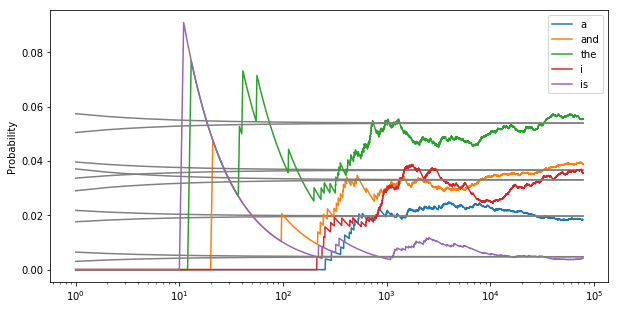

In [81]:
y = np.arange(1,size+1).reshape(size,1)
z = np.cumsum(x,axis=0) / y
key = ['a', 'and', 'the', 'i', 'is']
plt.figure(figsize=(10,5))
for i in range(5):
    plt.semilogx(y,z[:,i],label = key[i])
    mean = np.mean(z[:,i])
    variance = np.var(z[:,i])
    plt.semilogx(y,(variance**0.5) * np.power(y,-0.5) + mean,'grey')
    plt.semilogx(y,-(variance**0.5) * np.power(y,-0.5) + mean,'grey')
plt.ylabel('Probability') #name the x
plt.legend(loc='best')
plt.show()


* Why can't we apply CLT directly?   
Answer: The relationship between words and words could not be independent.
* How would we have to change the text for it to apply?    
Arrange the words in text in a random order.
* Why does it still work quite well?    
Because it has a great number of words, which seems eliminate the effect of relevance.

## 3. Denominator-layout notation

We used the numerator-layout notation for matrix calculus in class, now let's examine the denominator-layout notation.

Given $x, y\in\mathbb R$, $\mathbf x\in\mathbb R^n$ and $\mathbf y \in \mathbb R^m$, we have

$$
\frac{\partial y}{\partial \mathbf{x}}=\begin{bmatrix}
\frac{\partial y}{\partial x_1}\\
\frac{\partial y}{\partial x_2}\\
\vdots\\
\frac{\partial y}{\partial x_n}
\end{bmatrix},\quad 
\frac{\partial \mathbf y}{\partial {x}}=\begin{bmatrix}
\frac{\partial y_1}{\partial x}, 
\frac{\partial y_2}{\partial x}, 
\ldots,
\frac{\partial y_m}{\partial x}
\end{bmatrix}
$$

and 

$$
\frac{\partial \mathbf y}{\partial \mathbf{x}}
=\begin{bmatrix}
\frac{\partial \mathbf y}{\partial {x_1}}\\
\frac{\partial \mathbf y}{\partial {x_2}}\\
\vdots\\
\frac{\partial \mathbf y}{\partial {x_3}}\\
\end{bmatrix}
=\begin{bmatrix}
\frac{\partial y_1}{\partial x_1}, 
\frac{\partial y_2}{\partial x_1},
\ldots,
\frac{\partial y_m}{\partial x_1}
\\ 
\frac{\partial y_1}{\partial x_2},
\frac{\partial y_2}{\partial x_2},
\ldots,
\frac{\partial y_m}{\partial x_2}\\ 
\vdots\\
\frac{\partial y_1}{\partial x_n},
\frac{\partial y_2}{\partial x_n},
\ldots,
\frac{\partial y_m}{\partial x_n}
\end{bmatrix}
$$

Questions: 

1. Assume $\mathbf  y = f(\mathbf u)$ and $\mathbf u = g(\mathbf x)$, write down the chain rule for $\frac {\partial\mathbf  y}{\partial\mathbf x}$
2. Given $\mathbf X \in \mathbb R^{m\times n},\ \mathbf w \in \mathbb R^n, \ \mathbf y \in \mathbb R^m$, assume $z = \| \mathbf X \mathbf w - \mathbf y\|^2$, compute $\frac{\partial z}{\partial\mathbf w}$.

1. $\frac{\partial \mathbf{y}}{\partial \mathbf{x}} = \frac{\partial \mathbf{y}}{\partial \mathbf{u}}\frac{\partial \mathbf{u}}{\partial \mathbf{x}}$


2. First we can decompose:

 $\mathbf{a} = \mathbf{X}\mathbf{w}$
 
 $\mathbf{b} = \mathbf{a}- \mathbf{y}$
 
 $z = \|\mathbf{b}\|^2$
 
 By using the chain rule, we get:
 
 $\frac{\partial z}{\partial \mathbf{w}} = \frac{\partial z}{\partial \mathbf{b}}\frac{\partial \mathbf{b}}{\partial \mathbf{a}}\frac{\partial \mathbf{a}}{\partial \mathbf{w}} 
 = \frac{\partial \|\mathbf{b}\|^2}{\partial \mathbf{b}}\frac{\partial \mathbf{a} -\mathbf{y}}{\partial \mathbf{a}}\frac{\partial \mathbf{X}\mathbf{w}}{\partial \mathbf{w}}
 = 2\mathbf{b}^\top \times \mathbf{I} \times \mathbf{X} = 2(\mathbf{X}\mathbf{w}-\mathbf{y})^\top \mathbf{X}^\top$


## 4. Numerical Precision

Given scalars `x` and `y`, implement the following `log_exp` function such that it returns 
$$-\log\left(\frac{e^x}{e^x+e^y}\right)$$.

In [14]:
def log_exp(x, y):
    ## add your solution here
    return (-1)*nd.log(nd.exp(x)/(nd.exp(x)+ nd.exp(y)))

Test your codes with normal inputs:

In [15]:
x, y = nd.array([2]), nd.array([3])
z = log_exp(x, y)
z


[1.3132617]
<NDArray 1 @cpu(0)>

Now implement a function to compute $\partial z/\partial x$ and $\partial z/\partial y$ with `autograd`

In [16]:
def grad(forward_func, x, y): 
    ## Add your codes here
    x.attach_grad()
    y.attach_grad()
    with autograd.record():
        z = forward_func(x,y)
    z.backward()
    print('x.grad =', x.grad)
    print('y.grad =', y.grad)

Test your codes, it should print the results nicely. 

In [17]:
grad(log_exp, x, y)

x.grad = 
[-0.7310586]
<NDArray 1 @cpu(0)>
y.grad = 
[0.7310586]
<NDArray 1 @cpu(0)>


But now let's try some "hard" inputs

In [22]:
x, y = nd.array([50]), nd.array([100])
grad(log_exp, x, y)

x.grad = 
[nan]
<NDArray 1 @cpu(0)>
y.grad = 
[nan]
<NDArray 1 @cpu(0)>


Does your code return correct results? If not, try to understand the reason. (Hint, evaluate `exp(100)`). Now develop a new function `stable_log_exp` that is identical to `log_exp` in math, but returns a more numerical stable result.

The reason: Overflow.

In [24]:
x, y = nd.array([50]), nd.array([100])
def stable_log_exp(x, y):
    ## Add your codes here
    if x < y:
        max = y
    else:
        max = x

    ex = x - max
    ey = y - max
    return (-1)* nd.log(nd.exp(ex)/(nd.exp(ex)+ nd.exp(ey)))

grad(stable_log_exp, x, y)


[-50.]
<NDArray 1 @cpu(0)> 
[0.]
<NDArray 1 @cpu(0)>
x.grad = 
[-1.]
<NDArray 1 @cpu(0)>
y.grad = 
[1.]
<NDArray 1 @cpu(0)>
